In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import pickle
import os
import sys
import shutil
import imageio
from IPython.display import HTML
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib.ticker import NullFormatter
%matplotlib inline

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

In [6]:
def dict_torch_to_numpy(mydict):
    for k,v in mydict.items():
        try:
            mydict[k] = v.cpu().numpy()
        except AttributeError:
            pass
    return mydict

def mean_and_std_bounds(nparray):
    N, c, k = nparray.shape
    nparray = nparray.reshape(N*c, k)
    mean, std = np.mean(nparray, axis=0), np.std(nparray, axis=0)
    lower, upper = (mean-2*std/np.sqrt(N*c), mean+2*std/np.sqrt(N*c))
    return mean, (lower, upper)

In [25]:
BASE_PATH = '/home/paul/LOCAL_logs/ZeroShotKT/CIFAR10/transition_curves/'
path_to_pickle_stepOnstudZero = BASE_PATH + 'steponstudZero/curves.pickle'
path_to_pickle_stepOnstudDist = BASE_PATH + 'steponstudDist/curves.pickle'
with open(path_to_pickle_stepOnstudDist, 'rb') as handle:
    CIFARcurves_stepOnstudDist = dict_torch_to_numpy(pickle.load(handle))
with open(path_to_pickle_stepOnstudZero, 'rb') as handle:
    CIFARcurves_stepOnstudZero = dict_torch_to_numpy(pickle.load(handle))

BASE_PATH = '/home/paul/LOCAL_logs/ZeroShotKT/SVHN/transition_curves/'
path_to_pickle_stepOnstudZero = BASE_PATH + 'steponstudZero/curves.pickle'
path_to_pickle_stepOnstudDist = BASE_PATH + 'steponstudDist/curves.pickle'
with open(path_to_pickle_stepOnstudZero, 'rb') as handle:
    SVHNcurves_stepOnstudZero = dict_torch_to_numpy(pickle.load(handle))
with open(path_to_pickle_stepOnstudDist, 'rb') as handle:
    SVHNcurves_stepOnstudDist = dict_torch_to_numpy(pickle.load(handle))

# Visualize single image transition curve for SVHN

0.09483228
0.11831446


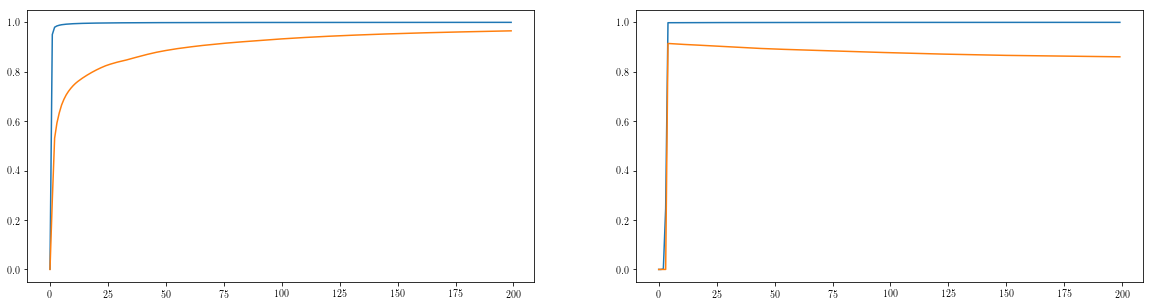

In [28]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im, class_idx = 115, 4

ax1.plot(SVHNcurves_stepOnstudZero['netA'][im, class_idx,:])
ax1.plot(SVHNcurves_stepOnstudZero['netB'][im, class_idx,:])
print(np.mean(np.abs(SVHNcurves_stepOnstudZero['netA'][im, class_idx,:] - SVHNcurves_stepOnstudZero['netB'][im, class_idx,:])))

ax2.plot(SVHNcurves_stepOnstudDist['netA'][im, class_idx,:])
ax2.plot(SVHNcurves_stepOnstudDist['netB'][im, class_idx,:])
print(np.mean(np.abs(SVHNcurves_stepOnstudDist['netA'][im, class_idx,:] - SVHNcurves_stepOnstudDist['netB'][im, class_idx,:])))

# Transition Error

In [31]:
K = 100

absdiff_studZero = np.abs(SVHNcurves_stepOnstudZero['netB'][:, :, 0:K] - SVHNcurves_stepOnstudZero['netA'][:, :, 0:K])
absdiff_studDist = np.abs(SVHNcurves_stepOnstudDist['netB'][:, :, 0:K] - SVHNcurves_stepOnstudDist['netA'][:, :, 0:K])
TE_zero_mean, TE_dist_mean = np.mean(absdiff_studZero), np.mean(absdiff_studDist)
#TE_zero_std, TE_dist_std = np.std(absdiff_studZero), np.std(absdiff_studDist) #high

print('SVHN zero shot: {:02.4f}'.format(TE_zero_mean))
print('SVHN dist: {:02.4f}'.format(TE_dist_mean))

SVHN zero shot: 0.0941
SVHN dist: 0.6361


In [30]:
K = 100

absdiff_studZero = np.abs(CIFARcurves_stepOnstudZero['netB'][:, :, 0:K] - CIFARcurves_stepOnstudZero['netA'][:, :, 0:K])
absdiff_studDist = np.abs(CIFARcurves_stepOnstudDist['netB'][:, :, 0:K] - CIFARcurves_stepOnstudDist['netA'][:, :, 0:K])
TE_zero_mean, TE_dist_mean = np.mean(absdiff_studZero), np.mean(absdiff_studDist), 

print('CIFAR zero shot: {:02.4f}'.format(TE_zero_mean))
print('CIFAR dist: {:02.4f}'.format(TE_dist_mean))

CIFAR zero shot: 0.2182
CIFAR dist: 0.7182


# Average curves

In [19]:
avgCIFARcurves_stepOnstudZero_teacher_mean, avgCIFARcurves_stepOnstudZero_teacher_bounds = mean_and_std_bounds(CIFARcurves_stepOnstudZero['netB'])
avgCIFARcurves_stepOnstudZero_studZero_mean, avgCIFARcurves_stepOnstudZero_studZero_bounds = mean_and_std_bounds(CIFARcurves_stepOnstudZero['netA'])
avgCIFARcurves_stepOnstudDist_teacher_mean, avgCIFARcurves_stepOnstudDist_teacher_bounds = mean_and_std_bounds(CIFARcurves_stepOnstudDist['netB'])
avgCIFARcurves_stepOnstudDist_studDist_mean, avgCIFARcurves_stepOnstudDist_studDist_bounds = mean_and_std_bounds(CIFARcurves_stepOnstudDist['netA'])

avgSVHNcurves_stepOnstudZero_teacher_mean, avgSVHNcurves_stepOnstudZero_teacher_bounds = mean_and_std_bounds(SVHNcurves_stepOnstudZero['netB'])
avgSVHNcurves_stepOnstudZero_studZero_mean, avgSVHNcurves_stepOnstudZero_studZero_bounds = mean_and_std_bounds(SVHNcurves_stepOnstudZero['netA'])
avgSVHNcurves_stepOnstudDist_teacher_mean, avgSVHNcurves_stepOnstudDist_teacher_bounds = mean_and_std_bounds(SVHNcurves_stepOnstudDist['netB'])
avgSVHNcurves_stepOnstudDist_studDist_mean, avgSVHNcurves_stepOnstudDist_studDist_bounds = mean_and_std_bounds(SVHNcurves_stepOnstudDist['netA'])


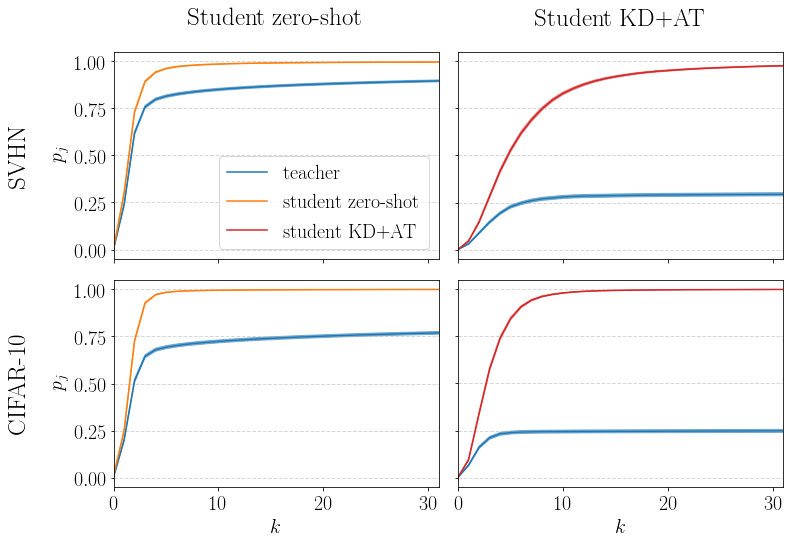

In [20]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax5 = fig.add_subplot(223)
ax6 = fig.add_subplot(224)

xlims, xstep = (0, 31), 10
title_size = 25
title_y = 1.1
subtitle_x = -9
label_size = 20
legend_size = 20
tick_size = 20
grid_params = {'axis':'y', 'linestyle': '--', 'linewidth': 1, 'alpha':0.5}

################################ SVHN

## steOnstudZero
x1 = np.arange(len(avgSVHNcurves_stepOnstudZero_teacher_mean))
line,  = ax1.plot(x1, avgSVHNcurves_stepOnstudZero_teacher_mean, label=r'teacher')
ax1.fill_between(x1, avgSVHNcurves_stepOnstudZero_teacher_bounds[0],  avgSVHNcurves_stepOnstudZero_teacher_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
line, = ax1.plot(x1, avgSVHNcurves_stepOnstudZero_studZero_mean, label=r'student zero-shot')
ax1.fill_between(x1, avgSVHNcurves_stepOnstudZero_studZero_bounds[0], avgSVHNcurves_stepOnstudZero_studZero_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax1.plot(x1, avgSVHNcurves_stepOnstudZero_studScr_mean,  label=r'student scratch')
#ax1.fill_between(x1, avgSVHNcurves_stepOnstudZero_studScr_bounds[0],  avgSVHNcurves_stepOnstudZero_studScr_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
myiter = iter(ax1._get_lines.prop_cycler)
myiter.__next__(); #to next color
line, = ax1.plot([-1], [0], label=r'student KD+AT')
#ax1.fill_between(x1, avgSVHNcurves_stepOnstudZero_studDist_bounds[0], avgSVHNcurves_stepOnstudZero_studDist_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)

ax1.set_xlim(xlims)
ax1.grid(**grid_params)
ax1.set_title(r'Student zero-shot', position=(0.5, title_y), fontsize=title_size)
ax1.set_ylabel(r'$p_j$', size=label_size)
#ax1.set_xlabel(r'$k$', size=label_size)
ax1.xaxis.set_ticks(np.arange(xlims[0],xlims[1], xstep))
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
ax1.legend(prop={'size': legend_size})
ax1.text(subtitle_x, 0.5, 'SVHN', fontsize=title_size, horizontalalignment='center', verticalalignment='center', rotation=90)

### steOnstudDist
x2 = np.arange(len(avgSVHNcurves_stepOnstudDist_teacher_mean))
line,  = ax2.plot(x2, avgSVHNcurves_stepOnstudDist_teacher_mean, label=r'teacher')
ax2.fill_between(x2, avgSVHNcurves_stepOnstudDist_teacher_bounds[0],  avgSVHNcurves_stepOnstudDist_teacher_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax2.plot(x2, avgSVHNcurves_stepOnstudDist_studZero_mean, label=r'student zero-shot')
#ax2.fill_between(x2, avgSVHNcurves_stepOnstudDist_studZero_bounds[0], avgSVHNcurves_stepOnstudDist_studZero_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax2.plot(x2, avgSVHNcurves_stepOnstudDist_studScr_mean,  label=r'student scratch')
#ax2.fill_between(x2, avgSVHNcurves_stepOnstudDist_studScr_bounds[0],  avgSVHNcurves_stepOnstudDist_studScr_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
myiter = iter(ax2._get_lines.prop_cycler)
myiter.__next__(); #to next color
myiter.__next__(); #to next color
line, = ax2.plot(x2, avgSVHNcurves_stepOnstudDist_studDist_mean, label=r'student KD+AT')
ax2.fill_between(x2, avgSVHNcurves_stepOnstudDist_studDist_bounds[0], avgSVHNcurves_stepOnstudDist_studDist_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)

ax2.set_xlim(xlims)
ax2.grid(**grid_params)
#ax2.set_xlabel(r'$k$', size=label_size)
ax2.xaxis.set_ticks(np.arange(xlims[0],xlims[1], xstep))
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())
ax2.tick_params(axis='both', which='major', labelsize=tick_size)
ax2.set_title(r'Student KD+AT', position=(0.5, title_y), fontsize=title_size)


################################ CIFAR 10

## steOnstudZero
x5 = np.arange(len(avgCIFARcurves_stepOnstudZero_teacher_mean))
line,  = ax5.plot(x5, avgCIFARcurves_stepOnstudZero_teacher_mean, label=r'teacher')
ax5.fill_between(x5, avgCIFARcurves_stepOnstudZero_teacher_bounds[0],  avgCIFARcurves_stepOnstudZero_teacher_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
line, = ax5.plot(x5, avgCIFARcurves_stepOnstudZero_studZero_mean, label=r'student zero-shot')
ax5.fill_between(x5, avgCIFARcurves_stepOnstudZero_studZero_bounds[0], avgCIFARcurves_stepOnstudZero_studZero_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax5.plot(x5, avgCIFARcurves_stepOnstudZero_studScr_mean,  label=r'student scratch')
#ax5.fill_between(x5, avgCIFARcurves_stepOnstudZero_studScr_bounds[0],  avgCIFARcurves_stepOnstudZero_studScr_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax5.plot(x5, avgCIFARcurves_stepOnstudZero_studDist_mean, label=r'student KD+AT')
#ax5.fill_between(x5, avgCIFARcurves_stepOnstudZero_studDist_bounds[0], avgCIFARcurves_stepOnstudZero_studDist_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)

ax5.set_xlim(xlims)
ax5.grid(**grid_params)
ax5.set_ylabel(r'$p_j$', size=label_size)
ax5.set_xlabel(r'$k$', size=label_size)
ax5.xaxis.set_ticks(np.arange(xlims[0],xlims[1], xstep))
ax5.tick_params(axis='both', which='major', labelsize=tick_size)
#ax5.legend(prop={'size': legend_size})
ax5.text(subtitle_x, 0.5, 'CIFAR-10', fontsize=title_size, horizontalalignment='center', verticalalignment='center', rotation=90)


### steOnstudDist
x6 = np.arange(len(avgCIFARcurves_stepOnstudDist_teacher_mean))
line,  = ax6.plot(x6, avgCIFARcurves_stepOnstudDist_teacher_mean, label=r'teacher')
ax6.fill_between(x6, avgCIFARcurves_stepOnstudDist_teacher_bounds[0],  avgCIFARcurves_stepOnstudDist_teacher_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax6.plot(x6, avgCIFARcurves_stepOnstudDist_studZero_mean, label=r'student zero-shot')
#ax6.fill_between(x6, avgCIFARcurves_stepOnstudDist_studZero_bounds[0], avgCIFARcurves_stepOnstudDist_studZero_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)
#line, = ax6.plot(x6, avgCIFARcurves_stepOnstudDist_studScr_mean,  label=r'student scratch')
#ax6.fill_between(x6, avgCIFARcurves_stepOnstudDist_studScr_bounds[0],  avgCIFARcurves_stepOnstudDist_studScr_bounds[1],  color=line.get_color(), alpha=0.5, interpolate=True)
myiter = iter(ax6._get_lines.prop_cycler)
myiter.__next__(); #to next color
myiter.__next__(); #to next color

line, = ax6.plot(x6, avgCIFARcurves_stepOnstudDist_studDist_mean, label=r'student KD+AT')
ax6.fill_between(x6, avgCIFARcurves_stepOnstudDist_studDist_bounds[0], avgCIFARcurves_stepOnstudDist_studDist_bounds[1], color=line.get_color(), alpha=0.5, interpolate=True)

ax6.set_xlim(xlims)
ax6.grid(**grid_params)
ax6.set_xlabel(r'$k$', size=label_size)
ax6.xaxis.set_ticks(np.arange(xlims[0],xlims[1], xstep))
ax6.yaxis.set_major_formatter(NullFormatter())
ax6.tick_params(axis='both', which='major', labelsize=tick_size)

###########################


plt.subplots_adjust(wspace=0.06, hspace=0.1)
fig.savefig('transition_curves.pdf', bbox_inches = 'tight');